This notebook explores the end-to-end benchmarking pipeline, including:

1. Initializing dataset and dataloader
2. Initializing model, either from our benchmark model definition or your own use cases
3. Running the model given input data
4. Defining criterion (e.g., MSE, RMSE)
5. Benchmarking against validation (observation) and testing (forecasting model) data

NOTE: This notebook does not contain the training pipeline...

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.utils.data import DataLoader

import xarray as xr
import numpy as np
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
sys.path.append('..')

from chaosbench import dataset, config, utils, criterion
from chaosbench.models import mlp, cnn, ae, fno, vit

import logging
logging.basicConfig(level=logging.INFO)

/burg/home/jn2808/.conda/envs/bench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset Preparation

First of all, we are initializing our Dataset and Dataloader that are going to be used for training / evaluation processes

In [3]:
# Specify train/val years + test benchmark
train_years = np.arange(2016, 2022)
val_years = np.arange(2022, 2023)

# Initialize Dataset objects
N_STEP = 1
LEAD_TIME = 1
train_dataset = dataset.S2SObsDataset(years=train_years, n_step=N_STEP, lead_time=LEAD_TIME)
val_dataset = dataset.S2SObsDataset(years=val_years, n_step=N_STEP, lead_time=LEAD_TIME)
test_dataset = dataset.S2SEvalDataset(s2s_name='ncep', years=val_years)


You have the flexibility to define your own DataLoader here, including the batch_size, etc..

In [4]:
# Define your own Dataloader
batch_size = 4

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
# Inspect a batch
_, train_x, train_y = next(iter(train_dataloader))
_, val_x, val_y = next(iter(val_dataloader))
_, test_x, test_y = next(iter(test_dataloader))

In [6]:
print(f'train/val x: {train_x.shape}') # Each tensor has the shape of (batch_size, params, level, lat, lon)
print(f'train/val y: {train_y.shape}') # Each tensor has the shape of (batch_size, step_size, params, level, lat, lon)

train/val x: torch.Size([4, 6, 10, 121, 240])
train/val y: torch.Size([4, 1, 6, 10, 121, 240])


In [7]:
print(f'test x: {test_x.shape}') # Each tensor has the shape of (batch_size, params, level, lat, lon)
print(f'test y: {test_y.shape}') # Each tensor has the shape of (batch_size, lead_time=44, params, level, lat, lon)

test x: torch.Size([4, 6, 10, 121, 240])
test y: torch.Size([4, 44, 6, 10, 121, 240])


## Modeling

Now that we have our Dataset and Dataloader setup, we can begin the modeling process. Our benchmark model architectures are defined under `chaosbench/models`

As a starter, we can define an autoencoder...

In [8]:
# Specify model specifications

model = fno.FNO2d()


In [9]:
# Run the model to get output
preds = model(train_x)
preds = preds.reshape(tuple([batch_size]) + tuple(torch.tensor(train_x.shape[1:])))
preds.shape


torch.Size([4, 6, 10, 121, 240])

## Evaluation

In [10]:
# We define what error metrics we want to compute (e.g., RMSE)
rmse = criterion.RMSE(lat_adjusted=False)


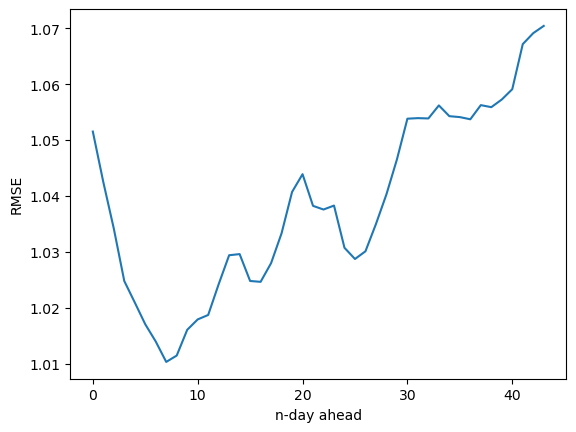

In [11]:
# Compute error over time against test benchmark data over long-term horizons (note: static prediction)
errors = list()
for step_idx in range(test_y.shape[1]):
    error = rmse(preds, test_y[:,step_idx])
    errors.append(error.item())
    preds = model(train_x)
    
# Plot error over n future timesteps
plt.plot(errors)
plt.xlabel('n-day ahead')
plt.ylabel('RMSE');
